# Assignment 6

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ Which mobile food vendor(s) sells at the most locations?

In [1]:
import geopandas as gpd
import sqlite3 as sql
import folium
import collections
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import pandas as pd
db = sql.connect("sf_data .sqlite")
dat_cat = pd.read_sql("SELECT * FROM mobile_food_permits where Status = 'APPROVED' ", db)
dat_loc = pd.read_sql("SELECT * FROM mobile_food_locations", db)
dat_sch = pd.read_sql("SELECT * FROM mobile_food_schedule", db)
dat_crime = pd.read_sql("SELECT * FROM crime", db)
dat_zillow = pd.read_sql("SELECT * FROM zillow", db)
dat_school = pd.read_sql("SELECT * FROM schools", db)
dat_noise = pd.read_sql("SELECT * FROM noise", db)
dat_park =  pd.read_sql("SELECT * FROM parks", db)
dat_parking =  pd.read_sql("SELECT * FROM parking", db)
dat_assult = pd.read_sql("SELECT * FROM crime where Category = 'ASSAULT' AND Datetime LIKE '2016%'", db)

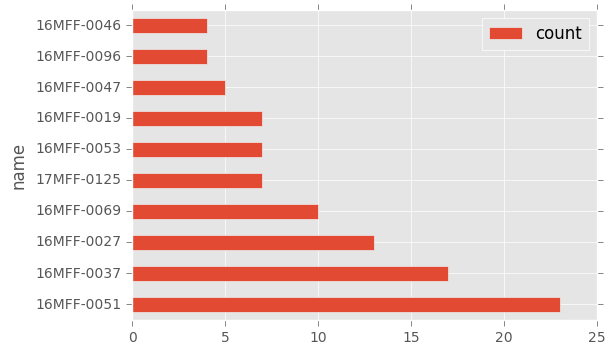

In [3]:
Freq = pd.read_sql(
    "SELECT L.permit, L.Status,R.locationid " 
    "FROM mobile_food_permits AS L INNER JOIN mobile_food_schedule AS R ON L.permit = R.permit", db
)
Freq = Freq.drop_duplicates().query("Status=='APPROVED'")
Freq = Freq[["permit"]]
Freq["count"] = np.repeat(1, 164, axis=None)
Freq = Freq.groupby(['permit']).sum().sort_values(by = "count",ascending = False).head(10)
Freq["name"] = Freq.index
Freq.plot(x = "name",y = "count",kind = "barh")
plt.show()

__Exercise 1.2.__ Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

In [4]:
##Question1: Which parts of the city are the most dangerous and what time are most dangerous in the city?
import geopandas as gpd
import shapely.geometry as geom
from folium.plugins import MarkerCluster

In [5]:
dat_assult["Datetime"][0].split(" ")[1].split(":")[0]
time = []
for i in dat_assult["Datetime"]:
    re = i.split(" ")[1].split(":")[0]
    time.append(re)

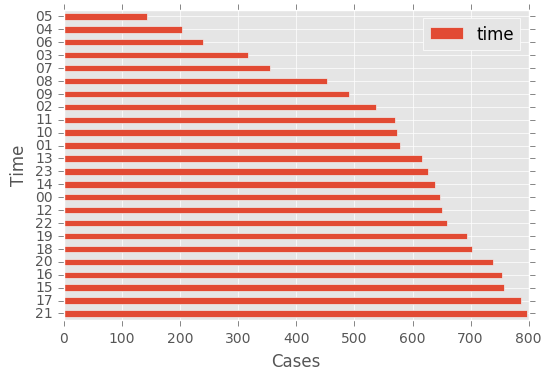

In [6]:
counter=dict(collections.Counter(time))
coun = pd.DataFrame(counter.keys(),counter.values())
coun["time"] = coun.index
coun = coun.sort_values(by ='time' , ascending = False)
coun.plot(x = 0,y = "time",kind = "barh")
plt.xlabel("Cases")
plt.ylabel("Time")
plt.show()

In [7]:
dat_assult['hour'] = pd.to_numeric(time)
dat_assult = dat_assult.query('hour == 15 or hour == 16 or hour == 17 or hour == 21')
lat = list(dat_assult["Lat"])
lon = list(dat_assult["Lon"])
lonlat = pd.DataFrame(lat,lon)
lonlat[1] = lonlat.index
SF_COORDINATES = (37.76, -122.45)
map_1 = folium.Map(SF_COORDINATES, zoom_start=12)
marker_cluster = folium.MarkerCluster("Public toilet cluster").add_to(map_1)
for each in lonlat.iterrows():
    folium.Marker(list((each[1][0],each[1][1]))).add_to(marker_cluster)

In [8]:
map_1

Our first goal is to find which part in SF is most dangrous and what time is the most dangerous.

Since there are too many cases in the criminal, we choose those cases that in 2016 so that we may speed up the loop.

From the bar plot we find out that most cases happen in 23:00-3:00, and we may conclude this period of time is most dangerous.Hence we may conclude the first half of night is most dangerous in SF.

Then we choose cases according to the most dangerous time


From the map, we can clearly saw that most cases happens at northeast in SF and we may assume these area is the most dangerous places.


Furthermore, south SF has the least cases happen and we may assume south SF is safetest.

In [9]:
#Question 2 What are the best times and places to find food vendors?
lat_food = list(dat_loc["Latitude"])
lon_food = list(dat_loc["Longitude"])
lonlat_food = pd.DataFrame(lat_food,lon_food)
lonlat_food[1] = lonlat_food.index

In [10]:
map_food = folium.Map(SF_COORDINATES, zoom_start=12)
marker_cluster_food = folium.MarkerCluster("Public toilet cluster food").add_to(map_food)
for each in lonlat_food.iterrows():
    folium.Marker(list((each[1][0],each[1][1]))).add_to(marker_cluster_food)

In [11]:
map_food

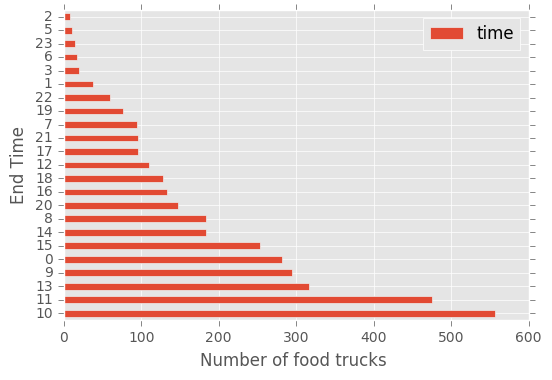

In [12]:
counter_end=dict(collections.Counter(dat_sch["EndHour"]))
counter_start = dict(collections.Counter(dat_sch["StartHour"]))
counter_end = pd.DataFrame(counter_end.keys(),counter_end.values())
counter_end["time"] = counter_end.index
counter_end = counter_end.sort_values(by ='time' , ascending = False)
counter_end.plot(x = 0,y = "time",kind = "barh")
plt.xlabel("Number of food trucks ")
plt.ylabel("End Time")
plt.show()

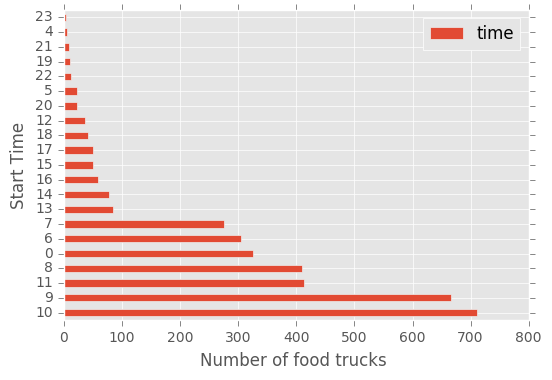

In [13]:
counter_start = pd.DataFrame(counter_start.keys(),counter_start.values())
counter_start["time"] = counter_start.index
counter_start = counter_start.sort_values(by ='time' , ascending = False)
counter_start.plot(x = 0,y = "time",kind = "barh")
plt.xlabel("Number of food trucks ")
plt.ylabel("Start Time")
plt.show()

From the map we can clearly find out that most of the food vendors located at east part of SF, which is nearly half of all the food vendors. So we may conclude that the east part of SF is the best place for people to find food. Moreover, the West and South part of SF has the least food vendors and we may conclude that the west and south part is the worst place to find food vendors  

Moreover, after seperating out the end and start time of every food vendor, we find out that most of the food vendors start at 9,10 and 11 at end at 10,11,13. So we may conclude that the best time to find the food truck is aroud 9 to 12, which is around lauch time. 

In [14]:
#Q3 Which parts of the city are the most and least expensive?
zips = gpd.read_file("cb_2015_us_zcta510_500k.shp")
q1_data = pd.read_sql("SELECT RegionName, AVG(MedianSoldPricePerSqft_AllHomes) AS Avg_Pri FROM zillow WHERE Date LIKE '2015%'GROUP BY RegionName ",db)
q1_data = q1_data.sort_values(by = 'Avg_Pri')
ex_zip = []
chp_zip = []
m = folium.Map(location = [37.7749, -122.4194],zoom_start = 12)
for index in range(0,3):
    ex_zip.append(str(int(q1_data.iloc[-index-1]['RegionName'])))
    chp_zip.append(str(int(q1_data.iloc[index]['RegionName'])))

for zip_code in ex_zip:
    m.choropleth(geo_str =  zips[zips.ZCTA5CE10.str.startswith(str(zip_code))]['geometry'].to_json(),fill_color='blue',legend_name='Expensive')
for zip_code in chp_zip:
    m.choropleth(geo_str =  zips[zips.ZCTA5CE10.str.startswith(str(zip_code))]['geometry'].to_json(),fill_color='yellow',legend_name='Expensive')
fig = folium.Figure(width = 800, height = 500)
fig.add_child(m)

The method that I used is to first cut SF into several areas according to the zipcode. The  I find the median price of each area and use map to show which part is most expensive and which part is the least expensive.

The blue part on the plot shows the three most expensive area in SF and the yellow part shows the least expensive part in SF

From the map we find out that the housing price in northeast part of SF is the most expensive
and the south part is least expensive.

The plot is reasonable since the northeast part is near the downtown and the sea and the south part near the country side.

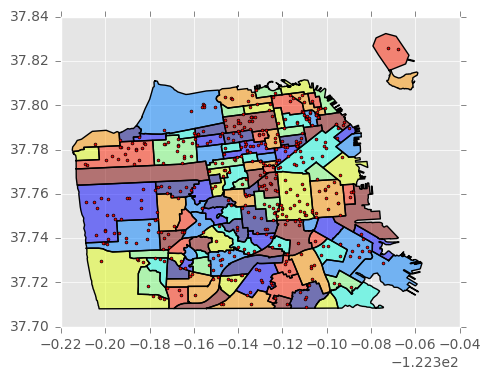

In [15]:
#Q4 Which part in SF has the most schools? Are they closely related to the housing price ?
zips = gpd.read_file("geo_export_407a0806-df5f-43e9-9652-1813b325f85f.shp")
base = zips.plot()
lonlat_sch = [geom.Point(lon, lat) for lon, lat in zip(dat_school.Lon, dat_school.Lat)]
dat_school.drop(["Lon", "Lat"], axis = 1)
dat_school = gpd.GeoDataFrame(dat_school, geometry = lonlat_sch, crs = {'init' :'epsg:4326'})
dat_school.plot(ax = base, marker = "o", color = "red")
plt.show()

The method I used to find out the location of school is to extract the lattitude and longitude in the sql dataset and plot the school as red point on the map above.

From the map we can clearly find out that most of the schools cluster in the northeast part in SF and there is a little bit of school located at the southwest part of SF. As for the middle part, we find out that 

Moreover, from Q3, we already find out that the housing price in Northeast part of SF is the most expensive so we may conclude that location of the school may affect the housing price. This is reasonable since parents want their children live near at the school

In [16]:
#Q5  Find out the parking in SF. Are they closely related to the Civic Plaza or Square
m = folium.Map(location = [37.7749, -122.4194],zoom_start = 12)
Civic_plaza = dat_park.query("Type == 'Civic Plaza or Square'").dropna()
parking = dat_parking.query("PrimeType == 'PPA'|PrimeType=='FPA'").dropna()
tmp = Civic_plaza[['Name','Lat','Lon']].dropna()
tmp1 = parking [['Lat','Lon']].dropna()
for Name, Lat, Lon in tmp.itertuples(index = False):
    folium.Marker([Lat, Lon], popup = Name).add_to(m)
lat_park = list(parking["Lat"])
lon_park = list(parking["Lon"])
lonlat_park = pd.DataFrame(lat_park,lon_park)
lonlat_park[1] = lonlat_park.index
marker_cluster_park = folium.MarkerCluster("Public toilet cluster park").add_to(m)
for each in lonlat_park.iterrows():
    folium.Marker(list((each[1][0],each[1][1]))).add_to(marker_cluster_park)

In [17]:
m

The method I used is to first extract the type of park "Civic Plaza or Square" and then extract the type of parking as "PPA" and "FPA" since these are the two types of public parking lots.

I used the package "Folium" and plot the Civic Plaza or Square as the blue point on the map. Then I used cluster to plot the "PPA" and "FPA" parking lot on the map. 

We find out that most of the Civic Plaza or Square located near the parking lot, especially in the very northeast part, which near the beach.

Moreover, we find out that some plazas that located a lit bit south do not located near the parking plot, which may causes inconvenient for customers to visit the plaza